<a href="https://colab.research.google.com/github/Saumik37/CVPR/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Classification: Manhattan (L1) vs Euclidean (L2) Distances

In [7]:
!gdown 1Z-SQl3J3qDoHQ-ghWFrAL_zOT9ez41sW -O animal_dataset.zip
!unzip -q -o animal_dataset.zip

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

%matplotlib inline

Downloading...
From: https://drive.google.com/uc?id=1Z-SQl3J3qDoHQ-ghWFrAL_zOT9ez41sW
To: /content/animal_dataset.zip
100% 20.6M/20.6M [00:00<00:00, 116MB/s] 


In [8]:
def load_data_fast(data_dir):
    classes = ['cat', 'dog', 'panda']
    rows = []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        rows.extend({'filepath': os.path.join(class_path, f), 'label': label, 'class_name': class_name} for f in files)

    df = pd.DataFrame(rows)
    if df.empty:
        return None, None, None, None

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    X = np.zeros((len(df), 32 * 32 * 3), dtype=np.uint8)
    y = df['label'].values

    for i, fp in enumerate(df['filepath']):
        try:
            img = Image.open(fp).resize((32, 32))
            if img.mode != 'RGB':
                img = img.convert('RGB')

            X[i, :] = np.asarray(img, dtype=np.uint8).flatten()
        except:
            pass

    return X, y, classes, df

if os.path.exists('animal_dataset'):
    X, y, classes, df_meta = load_data_fast('animal_dataset')
    print(f"Data Loaded. Shape of X: {X.shape}")
    print(df_meta.head())
else:
    print("Dataset not found.")

Data Loaded. Shape of X: (300, 3072)
                               filepath  label class_name
0  animal_dataset/panda/panda_00048.jpg      2      panda
1  animal_dataset/panda/panda_00049.jpg      2      panda
2     animal_dataset/dog/dogs_00097.jpg      1        dog
3     animal_dataset/cat/cats_00100.jpg      0        cat
4  animal_dataset/panda/panda_00072.jpg      2      panda


2. k-Nearest Neighbors (k-NN) Implementation

In [9]:
class KNN:
    def __init__(self, k=3, metric='l2'):
        self.k = k
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        num_test = X_test.shape[0]
        y_pred = np.zeros(num_test, dtype=int)

        for i in range(num_test):
            diff = self.X_train.astype(float) - X_test[i].astype(float)

            if self.metric == 'l1':
                distances = np.sum(np.abs(diff), axis=1)
            else:
                distances = np.sqrt(np.sum(diff**2, axis=1))

            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            y_pred[i] = np.argmax(np.bincount(k_nearest_labels, minlength=3))

        return y_pred

3. 5-Fold Cross-Validation

In [10]:
def cross_validate(X, y, k_values, num_folds=5):
    fold_size = len(X) // num_folds
    results_l1 = []
    results_l2 = []

    print(f"Running {num_folds}-Fold Cross-Validation on RGB data...")

    for k in k_values:
        acc_l1 = []
        acc_l2 = []

        for fold in range(num_folds):
            start = fold * fold_size
            end = (fold + 1) * fold_size

            X_val = X[start:end]
            y_val = y[start:end]

            X_train = np.concatenate((X[:start], X[end:]))
            y_train = np.concatenate((y[:start], y[end:]))

            knn_l1 = KNN(k=k, metric='l1')
            knn_l1.fit(X_train, y_train)
            preds_l1 = knn_l1.predict(X_val)
            acc_l1.append(np.mean(preds_l1 == y_val))

            knn_l2 = KNN(k=k, metric='l2')
            knn_l2.fit(X_train, y_train)
            preds_l2 = knn_l2.predict(X_val)
            acc_l2.append(np.mean(preds_l2 == y_val))

        results_l1.append(acc_l1)
        results_l2.append(acc_l2)

        print(f"K={k}: L1 Mean Acc={np.mean(acc_l1):.3f}, L2 Mean Acc={np.mean(acc_l2):.3f}")

    return results_l1, results_l2

k_values = [1, 3, 5, 8, 10, 12, 15, 20, 50]

if 'X' in locals():
    l1_all_accuracies, l2_all_accuracies = cross_validate(X[:1000], y[:1000], k_values)

Running 5-Fold Cross-Validation on RGB data...
K=1: L1 Mean Acc=0.470, L2 Mean Acc=0.407
K=3: L1 Mean Acc=0.450, L2 Mean Acc=0.400
K=5: L1 Mean Acc=0.427, L2 Mean Acc=0.407
K=8: L1 Mean Acc=0.450, L2 Mean Acc=0.430
K=10: L1 Mean Acc=0.447, L2 Mean Acc=0.423
K=12: L1 Mean Acc=0.453, L2 Mean Acc=0.437
K=15: L1 Mean Acc=0.450, L2 Mean Acc=0.417
K=20: L1 Mean Acc=0.447, L2 Mean Acc=0.433
K=50: L1 Mean Acc=0.427, L2 Mean Acc=0.397


4. Results and Analysis

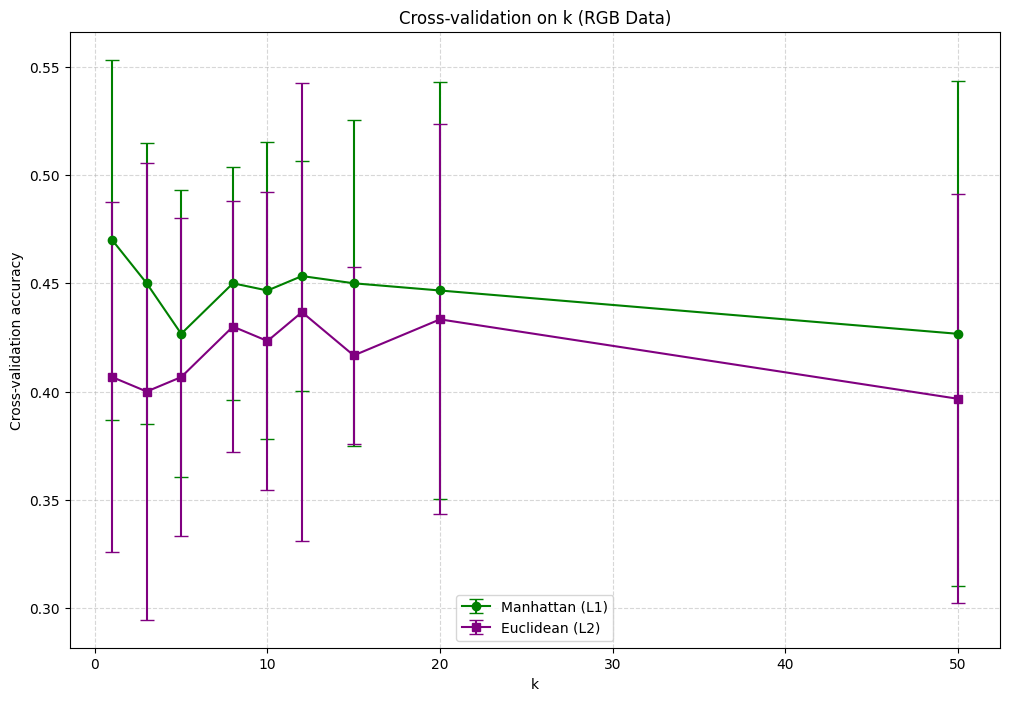

In [11]:
if 'l1_all_accuracies' in locals():
    l1_means = [np.mean(acc) for acc in l1_all_accuracies]
    l1_stds = [np.std(acc) for acc in l1_all_accuracies]

    l2_means = [np.mean(acc) for acc in l2_all_accuracies]
    l2_stds = [np.std(acc) for acc in l2_all_accuracies]

    plt.figure(figsize=(12,8))

    plt.errorbar(k_values, l1_means, yerr=l1_stds, fmt='-o',
                 label='Manhattan (L1)', color='green', capsize=5)

    plt.errorbar(k_values, l2_means, yerr=l2_stds, fmt='-s',
                 label='Euclidean (L2)', color='purple', capsize=5)

    plt.title('Cross-validation on k (RGB Data)')
    plt.xlabel('k')
    plt.ylabel('Cross-validation accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

5 Top 5 Predictions

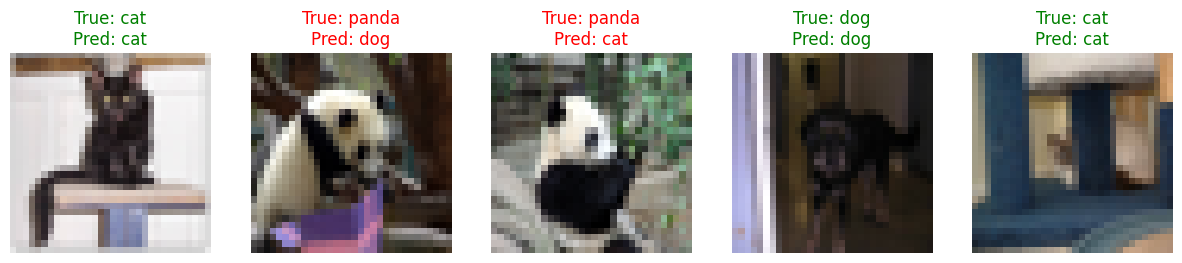

In [12]:
if 'X' in locals():
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    knn = KNN(k=5, metric='l1')
    knn.fit(X_train, y_train)

    if len(X_test) >= 5:
        indices = np.random.choice(len(X_test), 5, replace=False)
        X_sample = X_test[indices]
        y_sample = y_test[indices]

        predictions = knn.predict(X_sample)

        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(X_sample[i].reshape(32, 32, 3))
            color = 'green' if classes[y_sample[i]] == classes[predictions[i]] else 'red'
            plt.title(f"True: {classes[y_sample[i]]}\nPred: {classes[predictions[i]]}", color=color)
            plt.axis('off')
        plt.show()